In [9]:
import numpy as np, pandas as pd, tensorflow as tf
import lightgbm as lgb
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.metrics import mean_squared_error as mse
from tensorflow.keras.utils import timeseries_dataset_from_array as loader
from UTILS import train_test_split_ts, forward_garch, nll_gb_exp, nll_gb_exp_eval, take_X_y
from arch import arch_model
import pyfiglet

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (18,4)
plt.rcParams['font.size'] = 15

log-realized volatility used as additional feature!
log-realized volatility used as additional feature!
[LightGBM] [Warning] Unknown parameter: true
[LightGBM] [Warning] Unknown parameter: true
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000710 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 3889, number of used features: 40
[LightGBM] [Warning] Unknown parameter: true
[LightGBM] [Warning] Using self-defined objective function
************************************************************
              __  __  ___  ____  _____ _     
             |  \/  |/ _ \|  _ \| ____| |    
             | |\/| | | | | | | |  _| | |    
             | |  | | |_| | |_| | |___| |___ 
             |_|  |_|\___/|____/|_____|_____|
                                             
 _______     _

C:\Users\Giorgio\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\Giorgio\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Giorgio\anaconda3\lib\site-packages\lightgbm\basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


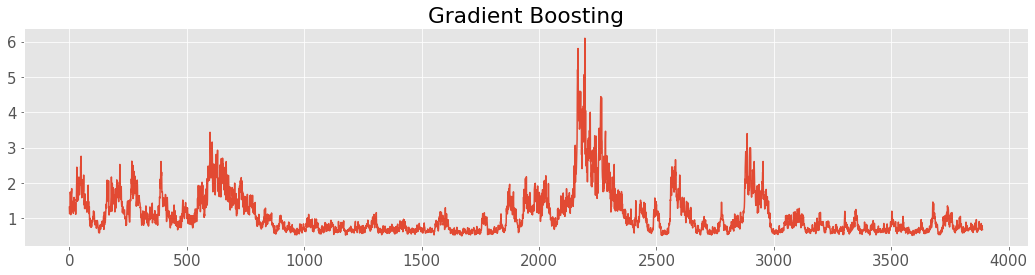

GB NLL:   5371


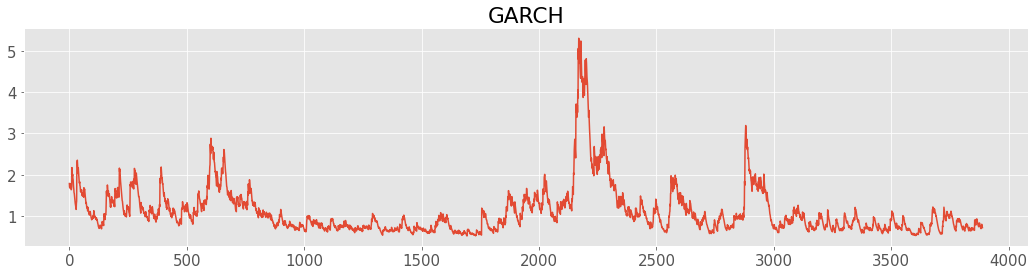

Garch NLL:   5507



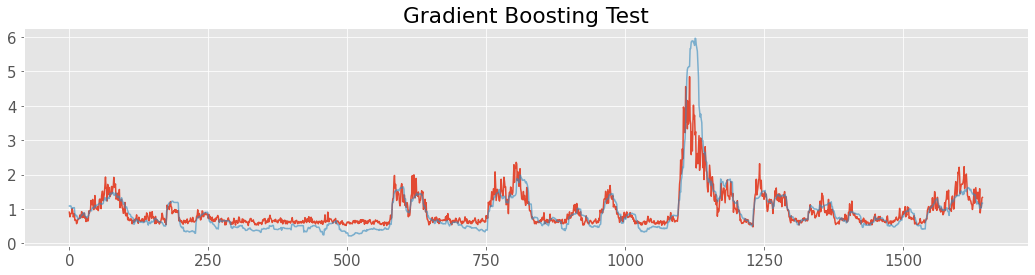

GB NLL:   2067
GB RMSE: 0.356


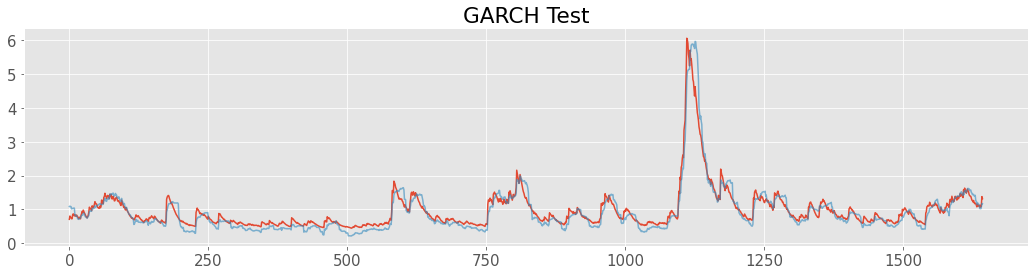

Garch NLL:   2053
Garch RMSE: 0.202


In [15]:
prices = yf.Ticker('^GSPC').history(start = '2000-01-01').Close
rets = 100*(prices.pct_change().dropna())
# rets = 100*(np.log(prices).diff().dropna())
rets_train, rets_test = train_test_split_ts(rets, .7)

#without garch vola as feature
lag = 20
X_train, y_train = take_X_y(rets_train, lag, take_rv = True, log_rv =True, reshape = True )
X_test, y_test = take_X_y(rets_test, lag, take_rv = True, log_rv =True, reshape = True)
lgb_train, lgb_test = lgb.Dataset(X_train, y_train, free_raw_data=False ),\
lgb.Dataset(X_test, y_test,  free_raw_data=False )

lgbm_params = {
#     'num_leaves'  : 2,
    'max_depth':1,
    'learning_rate' : .2,
    'boosting':'gbdt',
    'num_iterations':200,
    'force_col_wise ':'true',
    'early_stopping_round':10,
    'tree_learner': 'serial' ,
    'bagging_fraction': 1,
    'feature_fraction': 1,
    'extra_trees':'true'
}

model = lgb.train(
    params = lgbm_params,
    train_set = lgb_train,
    valid_sets = lgb_test,
    fobj  = nll_gb_exp,
    feval = nll_gb_exp_eval,
    verbose_eval = False
)

print(60*'*')
print(pyfiglet.figlet_format("             MODEL\nEVALUATION"))
print(60*'*')

out = model.predict(X_train)
plt.plot(np.exp(out)**.5)
plt.title('Gradient Boosting')
plt.show()

print('GB NLL: {:6.0f}'.format(nll_gb_exp_eval(out, lgb_train)[1]))

garch = arch_model(lgb_train.get_label(), mean = 'Constant', vol = 'GARCH', p=1, q=1)
fit = garch.fit(disp = False)
g_vol = fit.conditional_volatility

plt.plot(g_vol)
plt.title('GARCH')
plt.show()
print('Garch NLL: {:6.0f}'.format(nll_gb_exp_eval(np.log(g_vol**2), lgb_train)[1]))
print()

plt.plot(np.exp(model.predict(X_test))**.5)
plt.plot(np.exp(X_test[:,-1]), alpha = .6, label = 'Realized Volatilty')
plt.title('Gradient Boosting Test')
plt.show()
print('GB NLL: {:6.0f}'.format(nll_gb_exp_eval(model.predict(X_test), lgb_test)[1]))
print('GB RMSE: {:1.3f}'.format(mse(np.exp(model.predict(X_test))**.5, np.exp(X_test[:,-1]))**.5))


g_vola_pred = forward_garch(tf.convert_to_tensor(y_test), tf.convert_to_tensor(y_train), fit).numpy().ravel()
plt.plot(g_vola_pred)
plt.plot( np.exp(X_test[:,-1]), alpha = .6, label = 'Realized Volatilty')
plt.title('GARCH Test')
plt.show()
print('Garch NLL: {:6.0f}'.format(nll_gb_exp_eval(np.log(g_vola_pred**2), lgb_test)[1]))
print('Garch RMSE: {:1.3f}'.format(mse(g_vola_pred, np.exp(X_test[:,-1]))**.5))

In [11]:
mse(np.exp(model.predict(X_test))**.5, np.exp(X_test[:,1]))

0.418901169625589